In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib_inline
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from statsmodels.regression.linear_model import RegressionResults

import is3_broker_rl

%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats("retina")
sns.set_style("whitegrid")

In [2]:
DATA_DIR = Path(is3_broker_rl.__file__).parent.parent / "data"
NOTEBOOKS_DIR = Path(is3_broker_rl.__file__).parent.parent / "notebooks"

In [3]:
def calc_converged_reward_index(df_reward: pd.DataFrame) -> pd.Index:
    return (
        df_reward.groupby("episode_id", sort=False, as_index=False)
        .mean(numeric_only=True)["reward"]
        .iloc[300:]
        .rolling(50)
        .mean()
        .idxmax()
    ) * 168

In [4]:
# t4_c2 = Trial 4, Training 2
df_reward_t4_c2 = pd.read_csv(DATA_DIR / "trial4_consumption_training2" / "consumption_reward.csv")
df_reward_t4_c2 = df_reward_t4_c2.loc[: calc_converged_reward_index(df_reward_t4_c2)]
# t4_c3 = Trial 4, Training 3
df_reward_t4_c3 = pd.read_csv(DATA_DIR / "trial4_consumption_training3" / "consumption_reward.csv")
df_reward_t4_c3 = df_reward_t4_c3.loc[: calc_converged_reward_index(df_reward_t4_c3)]
# t4_c3 = Trial 4, Training 4
df_reward_t4_c4 = pd.read_csv(DATA_DIR / "trial4_consumption_training4" / "consumption_reward.csv")
df_reward_t4_c4 = df_reward_t4_c4.loc[: calc_converged_reward_index(df_reward_t4_c4)]
# t4_c3 = Trial 4, Training 5
df_reward_t4_c5 = pd.read_csv(DATA_DIR / "trial4_consumption_training5" / "consumption_reward.csv")
df_reward_t4_c5 = df_reward_t4_c5.loc[: calc_converged_reward_index(df_reward_t4_c5)]

### Correlation between `capacity_costs` and `consumption_share`

In [5]:
df_reward_t4_c2.groupby("episode_id").mean(numeric_only=True)[["reward", "consumptionShare", "capacity_costs"]].corr()

,reward,consumptionShare,capacity_costs
reward,1.000000,-0.339889,0.824706
consumptionShare,-0.339889,1.000000,-0.654665
capacity_costs,0.824706,-0.654665,1.000000


### Piece-wise linear penalty for consumption share

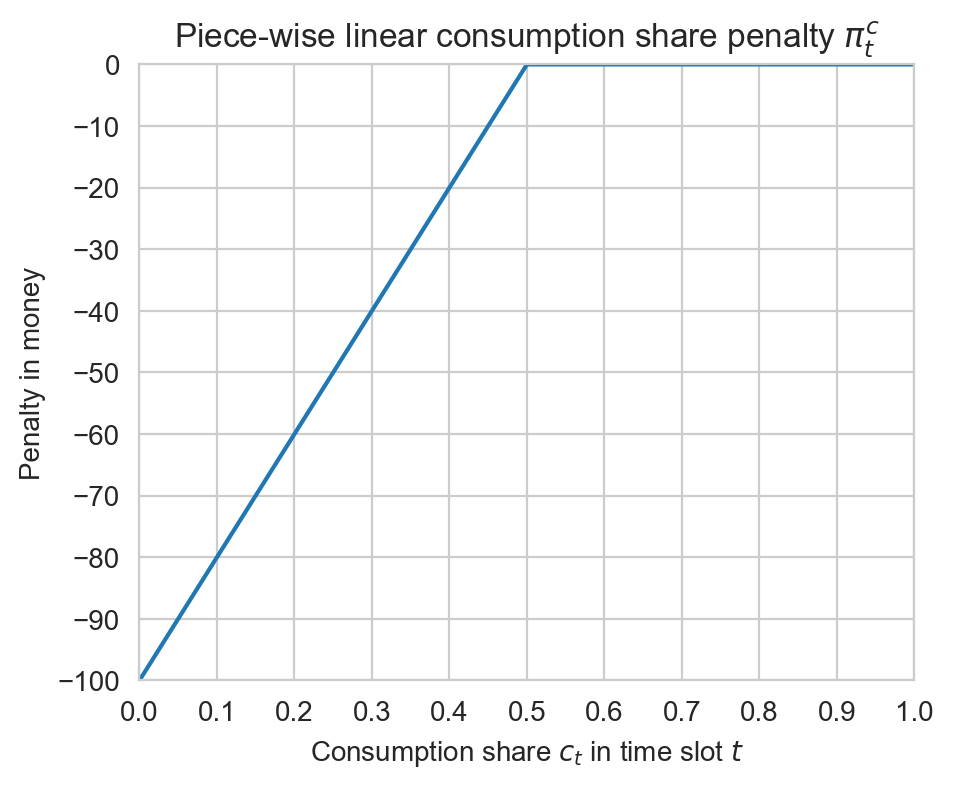

In [6]:
fig, ax = plt.subplots(figsize=(5, 4))
x = np.linspace(0, 1, 1000)
y = (0.5 - x) * -100 * np.power(0.5, -1)
y[y > 0] = 0
sns.lineplot(x=x, y=y, ax=ax)
ax.set_xmargin(0)
ax.set_ylim(-100, 0)
ax.xaxis.set_ticks(np.arange(0, 1.1, 0.1))
ax.yaxis.set_ticks(np.arange(-100, 10, 10))
ax.set_xlabel("Consumption share $c_t$ in time slot $t$")
ax.set_ylabel("Penalty in money")
ax.set_title("Piece-wise linear consumption share penalty $\pi_t^c$")
fig.savefig(NOTEBOOKS_DIR / "figures" / "piece-wise_linear_penalty.pdf")

### Confidence interval for reward function slope coefficient with and without customer groups feature

In [7]:
def fit_episodic_reward_ols(df_reward: pd.DataFrame):
    df_episodic_reward = (
        df_reward.groupby("episode_id", sort=False, as_index=False)
        .mean(numeric_only=True)["reward"]
        .rolling(window=50)
        .mean()
        .dropna()
    )
    X = df_episodic_reward.index.to_numpy()
    X = sm.add_constant(X)
    y = df_episodic_reward.to_numpy()
    df_episodic_reward = sm.OLS(y, X)
    reg_results = df_episodic_reward.fit()
    return reg_results, X, y

In [8]:
def plot_reg_results_with_ci(X, y, reg_results, ax, alpha=0.01):
    sns.lineplot(x=X[:, 1], y=y, ax=ax)
    sns.lineplot(x=X[:, 1], y=np.dot(X, reg_results.params), ax=ax)
    sns.lineplot(
        x=X[:, 1],
        y=np.dot(X, reg_results.conf_int(alpha=alpha)[:, 1]),
        linestyle="--",
        color="green",
        label=f"CI ($alpha = {alpha:.0%}$%)",
        ax=ax,
    )
    sns.lineplot(
        x=X[:, 1],
        y=np.dot(X, reg_results.conf_int(alpha=alpha)[:, 0]),
        linestyle="--",
        color="green",
        ax=ax,
    )

In [9]:
t4_c2_reward_reg_results, t4_c2_reward_X, t4_c2_reward_y = fit_episodic_reward_ols(df_reward_t4_c2)
t4_c3_reward_reg_results, t4_c3_reward_X, t4_c3_reward_y = fit_episodic_reward_ols(df_reward_t4_c3)

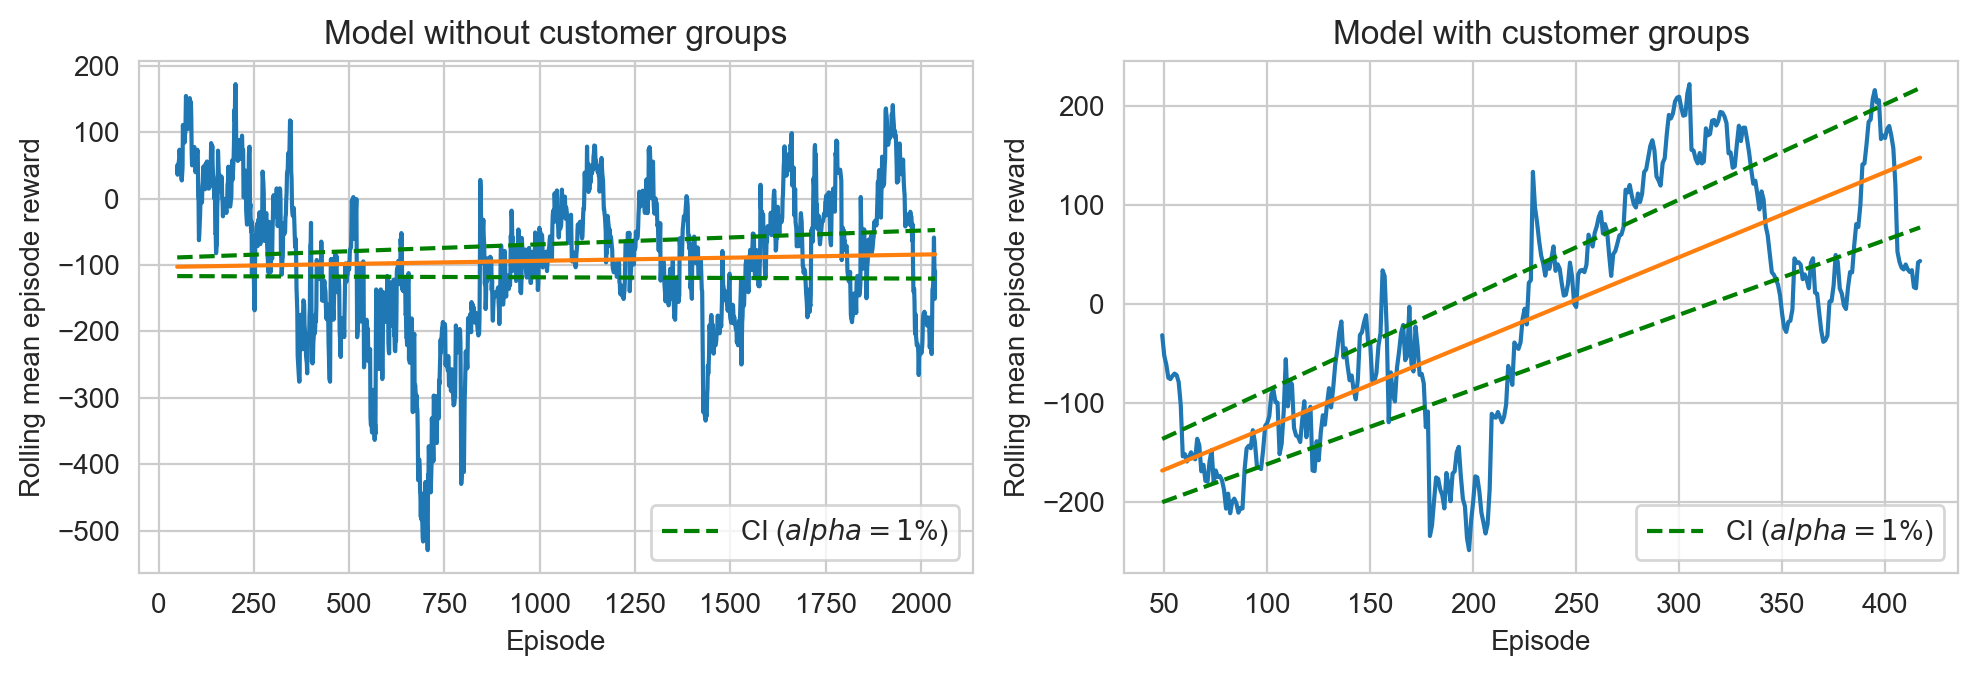

In [10]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 3.5))

plot_reg_results_with_ci(t4_c2_reward_X, t4_c2_reward_y, t4_c2_reward_reg_results, ax1)
ax1.set_ylabel("Rolling mean episode reward")
ax1.set_xlabel("Episode")
ax1.set_title("Model without customer groups")
ax1.legend(loc="lower right")

plot_reg_results_with_ci(t4_c3_reward_X, t4_c3_reward_y, t4_c3_reward_reg_results, ax2)
ax2.set_ylabel("Rolling mean episode reward")
ax2.set_xlabel("Episode")
ax2.set_title("Model with customer groups")
ax2.legend(loc="lower right")

fig.tight_layout()
fig.savefig(NOTEBOOKS_DIR / "figures" / "reward_customer_groups.pdf")

In [11]:
t4_c3_reward_reg_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.552
Model:                            OLS   Adj. R-squared:                  0.551
Method:                 Least Squares   F-statistic:                     451.7
Date:                Fri, 04 Nov 2022   Prob (F-statistic):           6.36e-66
Time:                        19:05:52   Log-Likelihood:                -2152.0
No. Observations:                 369   AIC:                             4308.
Df Residuals:                     367   BIC:                             4316.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -210.2858     10.360    -20.297      0.000    -230.659    -189.913
x1             0.8595      0.040     21.254      0.000       0.780       0.939
==============================================================================
Omnibus:                       15.923   Durbin-Watson:                   0.073
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               10.347
Skew:                          -0.273   Prob(JB):                      0.00566
Kurtosis:                       2.388   Cond. No.                         616.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [12]:
t4_c3_reward_reg_results.conf_int(alpha=0.01)

array([[-237.11176884, -183.45973305],
       [   0.75477809,    0.96419717]])

In [13]:
t4_c2_reward_reg_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     4.583
Date:                Fri, 04 Nov 2022   Prob (F-statistic):             0.0324
Time:                        19:05:52   Log-Likelihood:                -12214.
No. Observations:                1989   AIC:                         2.443e+04
Df Residuals:                    1987   BIC:                         2.444e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -103.0632      5.228    -19.713      0.000    -113.317     -92.810
x1             0.0094      0.004      2.141      0.032       0.001       0.018
==============================================================================
Omnibus:                      141.235   Durbin-Watson:                   0.046
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              187.300
Skew:                          -0.619   Prob(JB):                     2.13e-41
Kurtosis:                       3.853   Cond. No.                     2.47e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.47e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [14]:
t4_c2_reward_reg_results.conf_int(alpha=0.01)

array([[-1.16543207e+02, -8.95831848e+01],
       [-1.92118822e-03,  2.07228968e-02]])

### Final cash position slope and two sample $t$-test for mean comparison

In [15]:
def fit_final_cash_ols(df_reward: pd.DataFrame):
    df_final_cash = (
        df_reward.groupby("gameId", sort=False, as_index=False)
        .last(numeric_only=True)["cashPosition"]
        .rolling(window=5)
        .mean()
        .dropna()
    )
    X = df_final_cash.index.to_numpy()
    X = sm.add_constant(X)
    y = df_final_cash.to_numpy()
    df_final_cash = sm.OLS(y, X)
    reg_results = df_final_cash.fit()
    return reg_results, X, y

In [16]:
t4_c2_cash_reg_results, t4_c2_cash_X, t4_c2_cash_y = fit_final_cash_ols(df_reward_t4_c2)
t4_c3_cash_reg_results, t4_c3_cash_X, t4_c3_cash_y = fit_final_cash_ols(df_reward_t4_c3)

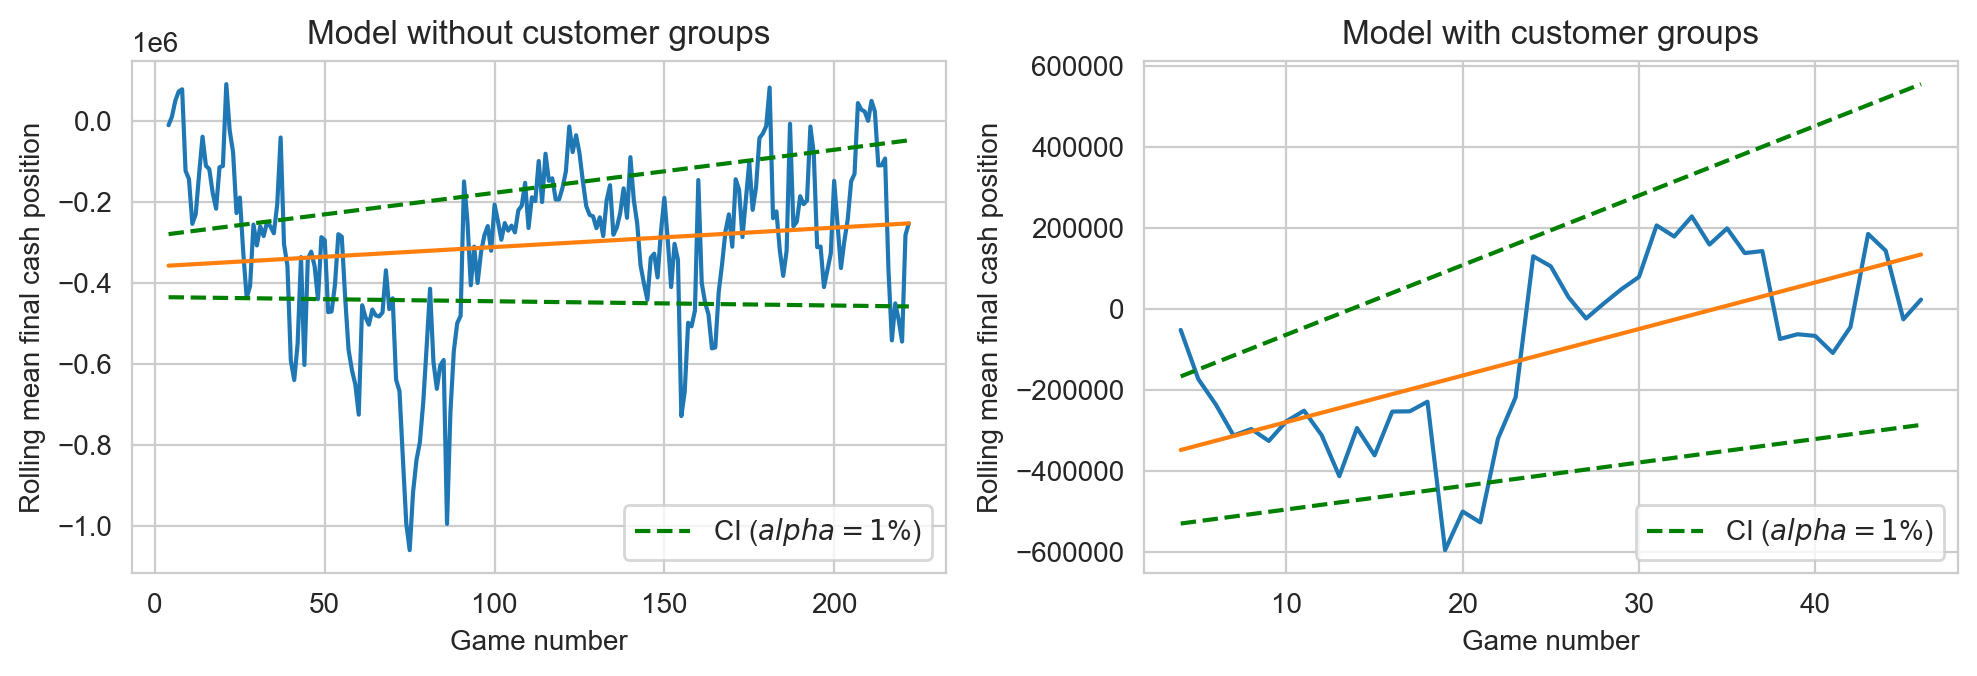

In [17]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 3.5))

plot_reg_results_with_ci(t4_c2_cash_X, t4_c2_cash_y, t4_c2_cash_reg_results, ax1, alpha=0.01)
ax1.set_ylabel("Rolling mean final cash position")
ax1.set_xlabel("Game number")
ax1.set_title("Model without customer groups")
ax1.legend(loc="lower right")

plot_reg_results_with_ci(t4_c3_cash_X, t4_c3_cash_y, t4_c3_cash_reg_results, ax2, alpha=0.01)
ax2.set_ylabel("Rolling mean final cash position")
ax2.set_xlabel("Game number")
ax2.set_title("Model with customer groups")
ax2.legend(loc="lower right")

fig.tight_layout()
fig.savefig(NOTEBOOKS_DIR / "figures" / "final_cash_customer_groups.pdf")

In [18]:
df_final_cash_t4_c2 = df_reward_t4_c2.groupby("gameId", sort=False, as_index=False).last(numeric_only=True)[
    "cashPosition"
]
df_final_cash_t4_c3 = df_reward_t4_c3.groupby("gameId", sort=False, as_index=False).last(numeric_only=True)[
    "cashPosition"
]

In [19]:
t_statistic, p_value, dof = sm.stats.ttest_ind(df_final_cash_t4_c2, df_final_cash_t4_c3)
print(f"{t_statistic=:.2f}, {p_value=:.4f}, {dof=:.0f}")

t_statistic=-2.88, p_value=0.0043, dof=268


In [20]:
df_final_cash_t4_c2.mean(), df_final_cash_t4_c3.mean()

(-303875.90775604686, -101216.27849908317)

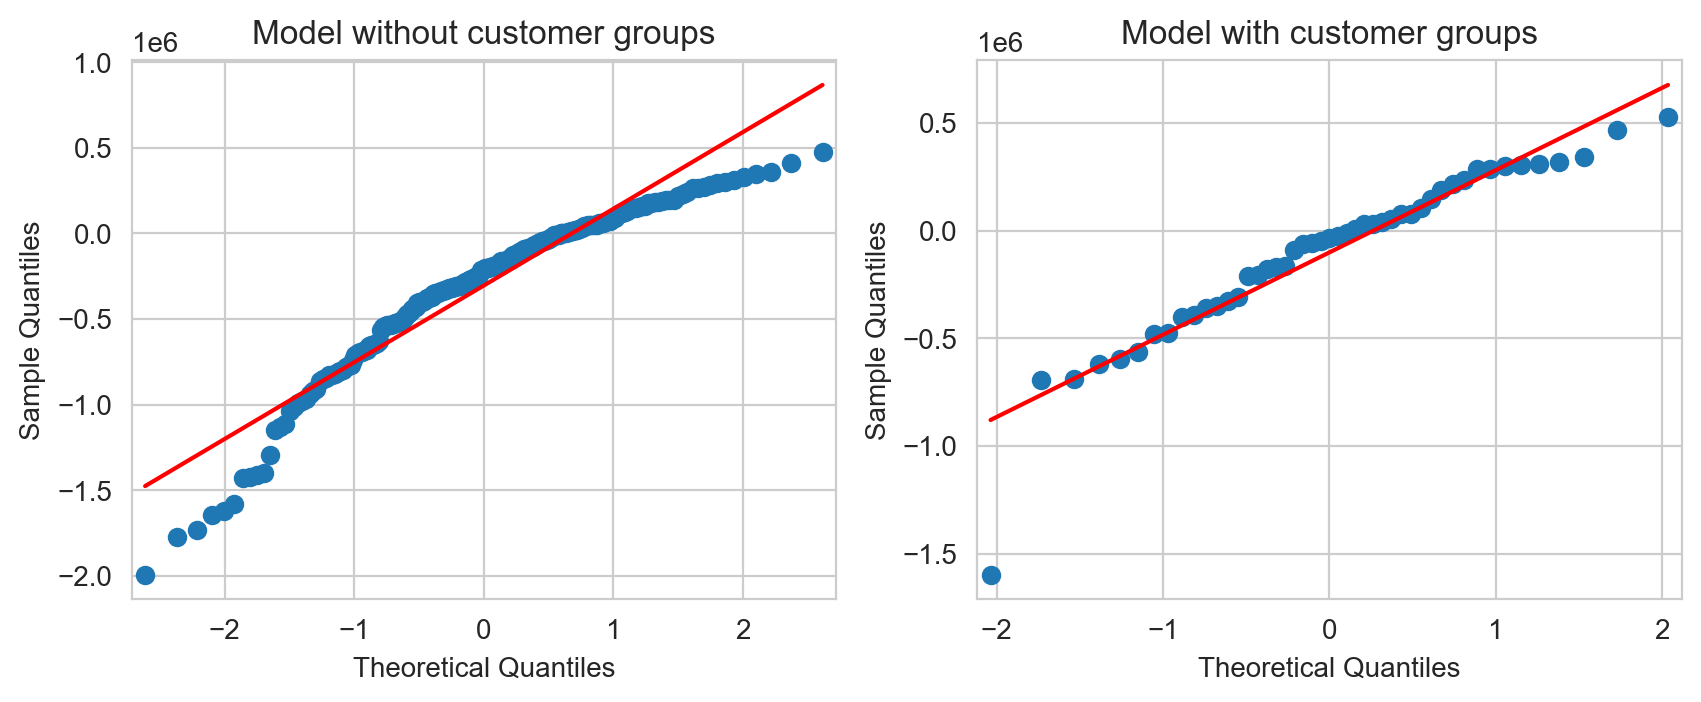

In [21]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 3.5))
sm.graphics.qqplot(df_final_cash_t4_c2, line="s", ax=ax1)
ax1.set_title("Model without customer groups")

sm.graphics.qqplot(df_final_cash_t4_c3, line="s", ax=ax2)
ax2.set_title("Model with customer groups")

fig.savefig(NOTEBOOKS_DIR / "figures" / "qqplot_final_cash.pdf")

### Customer groups share

In [22]:
def get_customer_groups_share(df_reward, key):
    customer_cols = [col for col in df_reward.columns if col.startswith("customer_")]
    df_customer_share = df_reward[customer_cols].rename(
        columns={col: col.replace("customer_", "").replace("_share", "") for col in customer_cols}
    )
    # Identifier for later visualization of different targetMarketShare penalty
    df_customer_share["targetMarketShare"] = key
    return df_customer_share.iloc[-10000:].drop(columns=["fc3", "fc2", "sf3", "sf2", "freezeco"])

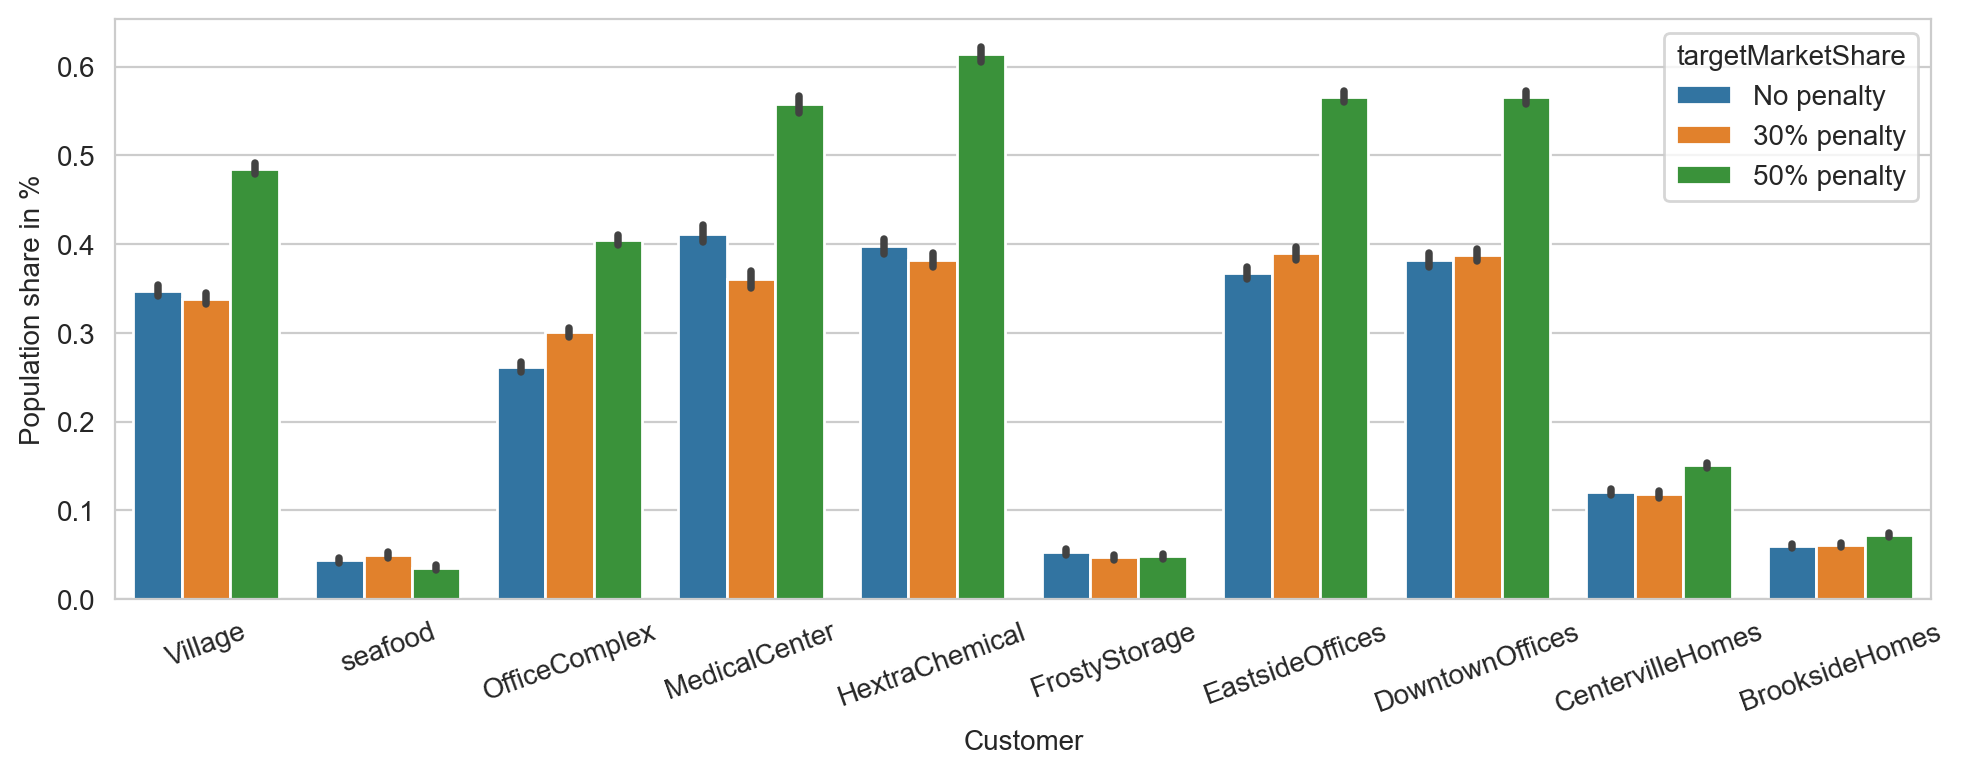

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
customer_groups_share_dfs = pd.concat(
    [
        get_customer_groups_share(df_reward_t4_c3, "No penalty"),
        get_customer_groups_share(df_reward_t4_c5, "30% penalty"),
        get_customer_groups_share(df_reward_t4_c4, "50% penalty"),
    ]
)
sns.barplot(
    x="variable",
    y="value",
    hue="targetMarketShare",
    data=customer_groups_share_dfs.melt(id_vars="targetMarketShare"),
    ax=ax,
)
ax.set_xlabel("Customer")
ax.set_ylabel("Population share in %")
ax.set_xticklabels(ax.get_xticklabels(), rotation=20)
fig.tight_layout()
fig.savefig(NOTEBOOKS_DIR / "figures" / "customer_group_share_targetMarketShare_hyperparam.pdf")